# Simulating Molecules using VQE for Qiskit 0.3+

In [1]:
#loading libraries
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import shapiro

#Qiskit - circuits and noise models
from qiskit.circuit.library import EfficientSU2,TwoLocal
from qiskit.opflow import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
#The library below will soon dissapear - it'll give you a warning until then..
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit.algorithms import VQE, NumPyEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver
#Loading all "useful" optimisers (NFT runs best!)
from qiskit.algorithms.optimizers  import COBYLA, SPSA, SLSQP, POWELL, GSLS, SciPyOptimizer, NFT

#All new qiskit features for electronic structure are now in qiskit_nature
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper,BravyiKitaevMapper
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.circuit.library import UCCSD
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.circuit.library import HartreeFock

#Providers for each instance
from qiskit.providers.aer import StatevectorSimulator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_1529/3873237850.py:16: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter


In [2]:
#this might make things faster
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

### Prepating the ground state
Here, we calculate the ground state energy for H$_2$ using a noisy simulator and error mitigation. 

First, we prepare the qubit operator representing the molecule's Hamiltonian:

In [3]:
#Define the MINI basis set (see emsl library for definition)
from pyscf import gto

MINI={'H': gto.basis.parse('''
H    S
      4.501800               0.070452
      0.681444               0.407826
      0.151398               0.647752
''')}

In [3]:
#Now define the molecule: H2 at a distance of 1.481696 angstroms

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 1.481696]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis='STO3G', driver_type=ElectronicStructureDriverType.PYSCF
)

#get properties, such as number of particles, etc..
properties = driver.run()
particle_number = properties.get_property(ParticleNumber)

print("System has:",particle_number.num_spin_orbitals, "spin orbitals")
print("System has:",particle_number.num_particles, "particles")

#setup the electronic structure problem and qbit mapping
es_problem = ElectronicStructureProblem(driver)

#--->Uncomment the one you want to use<---
#qubit_converter = QubitConverter(ParityMapper()) #4 qubits
#qubit_converter = QubitConverter(JordanWignerMapper()) #4 qubits
##qubit_converter = QubitConverter(BravyiKitaevMapper()) #4 qubits <------ used in report

##qubit_converter = QubitConverter(ParityMapper(),two_qubit_reduction=True) #2 qubits <------ used in report

#qubit_converter = QubitConverter(ParityMapper(),two_qubit_reduction=True,z2symmetry_reduction='auto') #1 qubit

#qubit_converter = QubitConverter(JordanWignerMapper(),z2symmetry_reduction='auto') #1 qubit
##qubit_converter = QubitConverter(BravyiKitaevMapper(),z2symmetry_reduction='auto') #1 qubit <------ used in report
#qubit_converter = QubitConverter(ParityMapper(),z2symmetry_reduction='auto') # 1 qubit 

System has: 4 spin orbitals
System has: (1, 1) particles


In [4]:
#Define numpy solver (which leads to the exact result exact)
numpy_solver = NumPyMinimumEigensolver()
#then solve the problem exactly (and classically, by disgonalisation) 
#Compute the reference energy
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
exact_solution = calc.solve(es_problem)
REFERENCE_energy=exact_solution.total_energies[0]

#Grab HF energy for correlation estimate
HF_energy=exact_solution.hartree_fock_energy

#Compute reference correlation energy
REFERENCE_ecorr=REFERENCE_energy-HF_energy
#Values in Hartrees!
print("Exact Result:", REFERENCE_energy, "HF energy:",HF_energy, "Exact correlation energy:",REFERENCE_ecorr)    

Exact Result: -1.0011251956327858 HF energy: -0.9163768770236478 Exact correlation energy: -0.08474831860913801


In [5]:
#Determine how many qubits we need
# Generate the second-quantized operators
second_q_ops = es_problem.second_q_ops()

#print(second_q_ops)
# Hamiltonian
main_op = second_q_ops[0]
print(main_op)

qubit_op = qubit_converter.convert(main_op, num_particles=particle_number.num_particles)
#Create the Hartree-Fock circuit
#print(qubit_op)

#HF-ansatz (closer to the original correlated ansatz)
print(qubit_op.num_qubits)
nqbits=qubit_op.num_qubits

Fermionic Operator
register length=4, number terms=14
  (0.2283532098308517+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.22835320983085167+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.22835320983085167+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.22835320983085167+0j) * ( -_0 +_1 -_2 +_3 ) ...
1


## This section defines a few ansatzs efficientSU2, an IBM-own ansatz and a UCCSD ansatz 
Only evaluate the one you need!

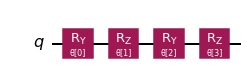

In [7]:
#Efficient SU2 test

#Qubit is number of spin orbitals - 3 symmetries 
ansatz = EfficientSU2(num_qubits=nqbits, reps=1, entanglement="full", \
                      insert_barriers=False)

ansatz.decompose().draw("mpl", style="iqx")

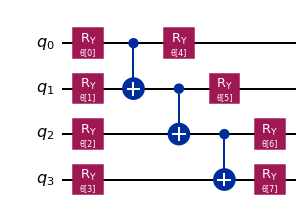

In [7]:
#Francesco-ansatz

#Qubit is number of spin orbitals - 3 symmetries 
ansatz = TwoLocal(nqbits, 'ry', 'cx', 'linear', reps=1, insert_barriers=False)
ansatz.decompose().draw("mpl", style="iqx")

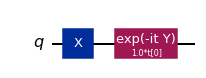

In [6]:
#UCCSD ansatz
init_state = HartreeFock(num_spin_orbitals=particle_number.num_spin_orbitals, 
                         num_particles=particle_number.num_particles, 
                         qubit_converter=qubit_converter)
ansatz = UCCSD(qubit_converter=qubit_converter, num_particles=particle_number.num_particles,  
               num_spin_orbitals=particle_number.num_spin_orbitals,
               reps=1, initial_state=init_state, generalized=False, preserve_spin=True)
ansatz.decompose().draw("mpl", style="iqx")

## Choose an optimiser and define a guess vector

In [7]:
optimizer = POWELL(maxiter=50)
print(ansatz.num_parameters)
np.random.seed(5)  # fix seed for reproducibility
#initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.random.uniform(-0.01,0.01,size=ansatz.num_parameters)

1


## Now choose a quantum instance

In [36]:
#exact state vector simulator (no noise)
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

In [32]:
# QASM simulator with no noise

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=8192)

In [8]:
#or a simulated quantum computer 

#here we use the jakarta machine as it's less noisy

#Don't forget to generate a token, and paste in the '' below
provider = IBMQ.enable_account('')

provider = IBMQ.get_provider(hub='ibm-q-education', group='hull-1', project='Advanced-Quantum')
backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   basis_gates=basis_gates,
                                   seed_transpiler=9,
                                   optimization_level=3,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30) # now adding error mitigation
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'sx', 'reset', 'id', 'x']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (3, 5)), ('cx', (5, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,))]


## Now run the VQE calculation

In [9]:
#Diagnostics variable to check how the optimisation went
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [10]:
#Setup the VQE solver with the ansatz, etc.. 
vqe_solver = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    quantum_instance=quantum_instance,
    callback=callback
)

In [11]:
#bk
#Quick test running 10 vqe to see how the numbers line up
ens=[]
for i in range(100):
    intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []}
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    res = calc.solve(es_problem)
    print("test number:",i,res.total_energies[0], "reference energy",REFERENCE_energy)
    ens.append(res.total_energies[0])

test number: 0 -1.0058159426599151 reference energy -1.0011251956327858
test number: 1 -1.0073068103324692 reference energy -1.0011251956327858
test number: 2 -1.003301201947927 reference energy -1.0011251956327858
test number: 3 -1.006323000658714 reference energy -1.0011251956327858
test number: 4 -1.004208798538445 reference energy -1.0011251956327858
test number: 5 -1.0069208673686345 reference energy -1.0011251956327858
test number: 6 -1.0040158745890646 reference energy -1.0011251956327858
test number: 7 -1.0014886885155976 reference energy -1.0011251956327858
test number: 8 -1.004282647458861 reference energy -1.0011251956327858
test number: 9 -1.0073722463708696 reference energy -1.0011251956327858
test number: 10 -1.0047526308021753 reference energy -1.0011251956327858
test number: 11 -1.0058205996867522 reference energy -1.0011251956327858
test number: 12 -1.007209328354779 reference energy -1.0011251956327858
test number: 13 -1.0058209000773048 reference energy -1.0011251956

Save your data

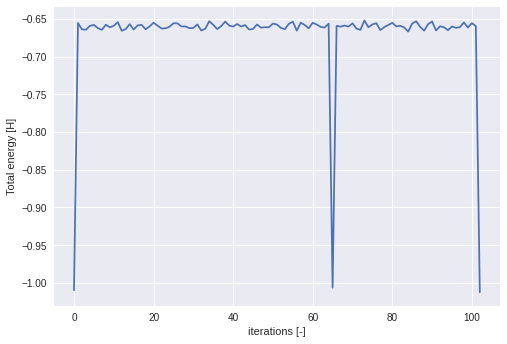

In [37]:
#plotting optimisation results for the last test only (remember to add the nuclear rep energy)
with plt.style.context('seaborn'):
    plt.plot(intermediate_info['energy']+res.nuclear_repulsion_energy)
    plt.xlabel('iterations [-]')
    plt.ylabel('Total energy [H]')
    plt.show()

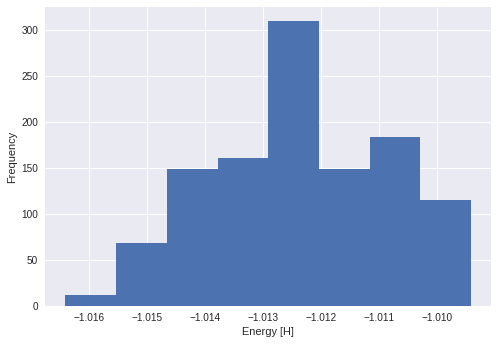

In [16]:
#Histogram of the energy data for the tests
with plt.style.context('seaborn'):
    plt.hist(ens,density=True,bins='auto')
    plt.xlabel('Energy [H]')
    plt.ylabel('Frequency')
    plt.show()

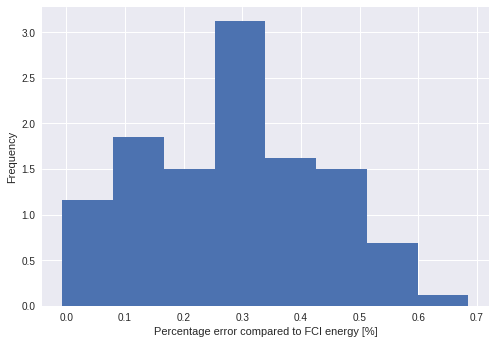

In [17]:
#Histogram of the percentage deviation from reference data for the tests

with plt.style.context('seaborn'):
    plt.hist(100*(np.array(ens)-REFERENCE_energy)/REFERENCE_energy,density=True,bins='auto')
    plt.xlabel('Percentage error compared to FCI energy [%]')
    plt.ylabel('Frequency')
    plt.show()

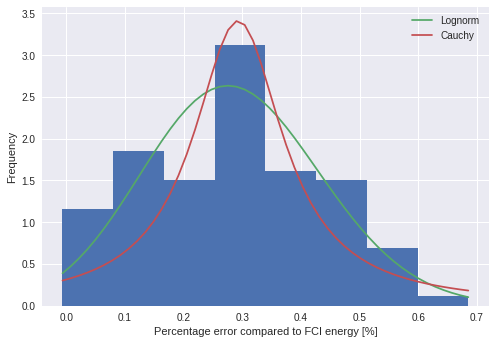

In [18]:
import scipy.stats
err =100*(np.array(ens)-REFERENCE_energy)/REFERENCE_energy

[s_fit,loc_fit,scale_fit] = scipy.stats.lognorm.fit(err)
[loc2_fit,scale2_fit] = scipy.stats.cauchy.fit(err)
x = np.linspace(np.min(err),np.max(err))

with plt.style.context('seaborn'):
    plt.hist(err,bins = 'auto',density = True) #plotting rating hist
    plt.plot(x,scipy.stats.lognorm.pdf(x,s_fit,loc=loc_fit,scale=scale_fit),label='Lognorm')
    plt.plot(x,scipy.stats.cauchy.pdf(x,loc=loc2_fit,scale=scale2_fit),label='Cauchy')
    plt.xlabel('Percentage error compared to FCI energy [%]')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


  Using cached fitter-1.4.0-py3-none-any.whl
  Using cached easydev-0.12.0-py3-none-any.whl
  Using cached colorlog-6.6.0-py2.py3-none-any.whl (11 kB)


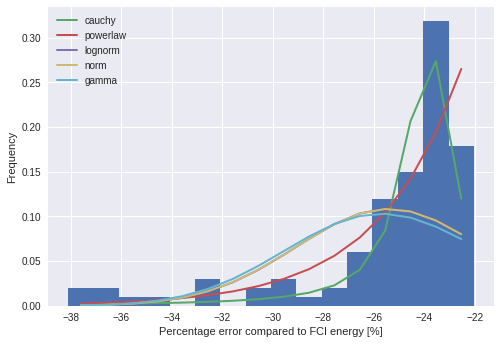

In [7]:
#!pip install fitter
from fitter import Fitter, get_common_distributions, get_distributions
with plt.style.context('seaborn'):
    f = Fitter(err, 
           distributions= get_common_distributions(),bins='auto')
#Using fitter to gather loads of different distributions and calculate aic to rank them 
    f.fit() #showing fits
    f.summary() #displaying summary table
    plt.xlabel('Percentage error compared to FCI energy [%]')
    plt.ylabel('Frequency')
    plt.show()

In [19]:
from scipy.stats import shapiro
#err = 100*(float(Ref_Energy)-np.array(vqe_6G))  #wrong way round think i did for a test

stat, p = shapiro(err)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.986, p=0.350
Probably Gaussian


In [53]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.2', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.34.2', 'qiskit-nature': '0.3.1', 'qiskit-finance': '0.3.1', 'qiskit-optimization': '0.3.1', 'qiskit-machine-learning': '0.3.0'}